In [1]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
data_dir = 'data_set'
class_names = sorted([subdir for subdir in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, subdir))])
num_classes = len(class_names)
data_gen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)


In [3]:
train_data_gen = data_gen.flow_from_directory(directory=data_dir,
                                              target_size=(224, 224),
                                              class_mode='categorical',
                                              shuffle=True,
                                              seed=123,
                                              subset='training')


Found 1854 images belonging to 10 classes.


In [4]:
val_data_gen = data_gen.flow_from_directory(directory=data_dir,
                                              target_size=(224, 224),
                                              class_mode='categorical',
                                              shuffle=True,
                                              seed=123,
                                              subset='validation')

Found 458 images belonging to 10 classes.


Text(0.5, 0.98, 'Sample images for 10 classes')

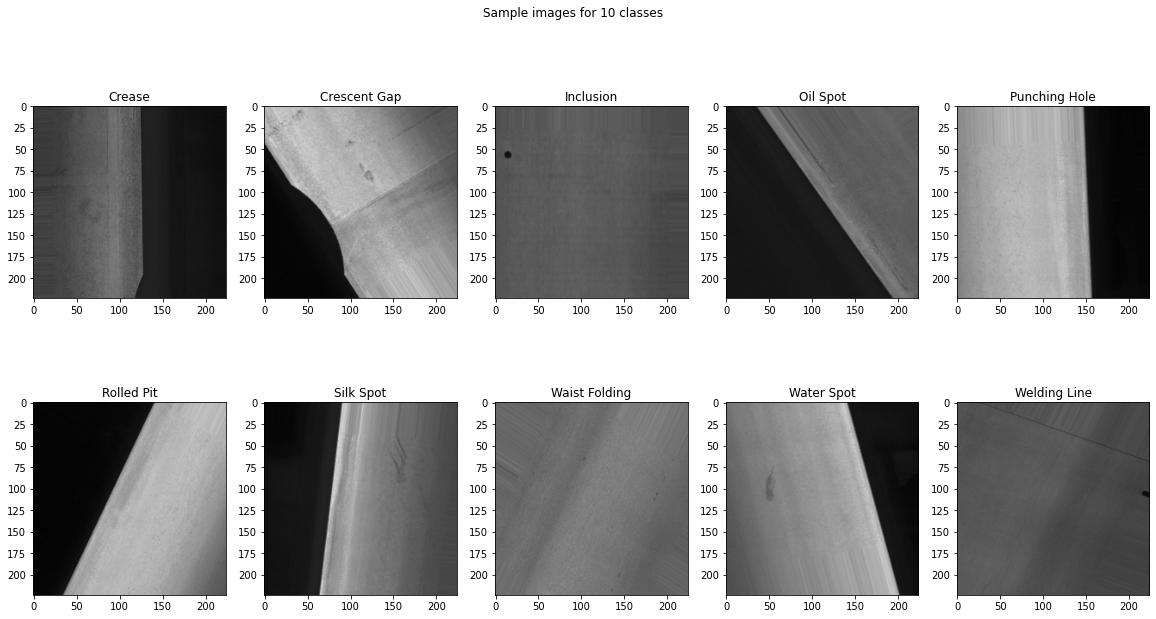

In [5]:
fig, axs = plt.subplots(2, 5, figsize=(20, 10))
axs = axs.ravel()
class_names = [name.replace("_", " ").title() for name in class_names]
for i in range(num_classes):
    images, labels = val_data_gen.next()
    axs[i].imshow(images[0])
    axs[i].set_title(class_names[i])
    axs[i].grid(False)
fig.suptitle(f"Sample images for {num_classes} classes")

In [6]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224,224,3))

model = keras.Sequential([
    base_model,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(train_data_gen.num_classes, activation='softmax')
])

model.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['accuracy'])


In [7]:
# Define the early stopping and model checkpoint callbacks
callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min'),
keras.callbacks.ModelCheckpoint(filepath='best_model.h5', save_best_only=True, monitor='val_loss', mode='min')]

# Unfreeze the last few layers of the base model
for layer in base_model.layers[-10:]:
    layer.trainable = True

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                20490     
Total params: 21,823,274
Trainable params: 21,788,842
Non-trainable params: 34,432
_________________________________________________________________


In [9]:
history = model.fit(
    train_data_gen,
    epochs=30,
    validation_data=val_data_gen,
    callbacks=callbacks
)

Epoch 1/30
58/58 [==============================] - 291s 5s/step - loss: 1.7761 - accuracy: 0.4099 - val_loss: 1.8210 - val_accuracy: 0.3952
Epoch 2/30
58/58 [==============================] - 279s 5s/step - loss: 1.1990 - accuracy: 0.6160 - val_loss: 1.3821 - val_accuracy: 0.5611
Epoch 3/30
58/58 [==============================] - 276s 5s/step - loss: 0.9184 - accuracy: 0.7012 - val_loss: 1.2282 - val_accuracy: 0.6026
Epoch 4/30
58/58 [==============================] - 284s 5s/step - loss: 0.7738 - accuracy: 0.7449 - val_loss: 0.9832 - val_accuracy: 0.6747
Epoch 5/30
58/58 [==============================] - 286s 5s/step - loss: 0.7182 - accuracy: 0.7621 - val_loss: 0.9522 - val_accuracy: 0.6921
Epoch 6/30
58/58 [==============================] - 287s 5s/step - loss: 0.6911 - accuracy: 0.7686 - val_loss: 0.9221 - val_accuracy: 0.6921
Epoch 7/30
58/58 [==============================] - 287s 5s/step - loss: 0.6292 - accuracy: 0.7859 - val_loss: 0.9019 - val_accuracy: 0.6987
Epoch 8/30
58

In [10]:
test_loss, test_acc = model.evaluate(val_data_gen)
print('Test accuracy:', test_acc)

15/15 [==============================] - 21s 1s/step - loss: 0.9305 - accuracy: 0.7467
Test accuracy: 0.7467249035835266


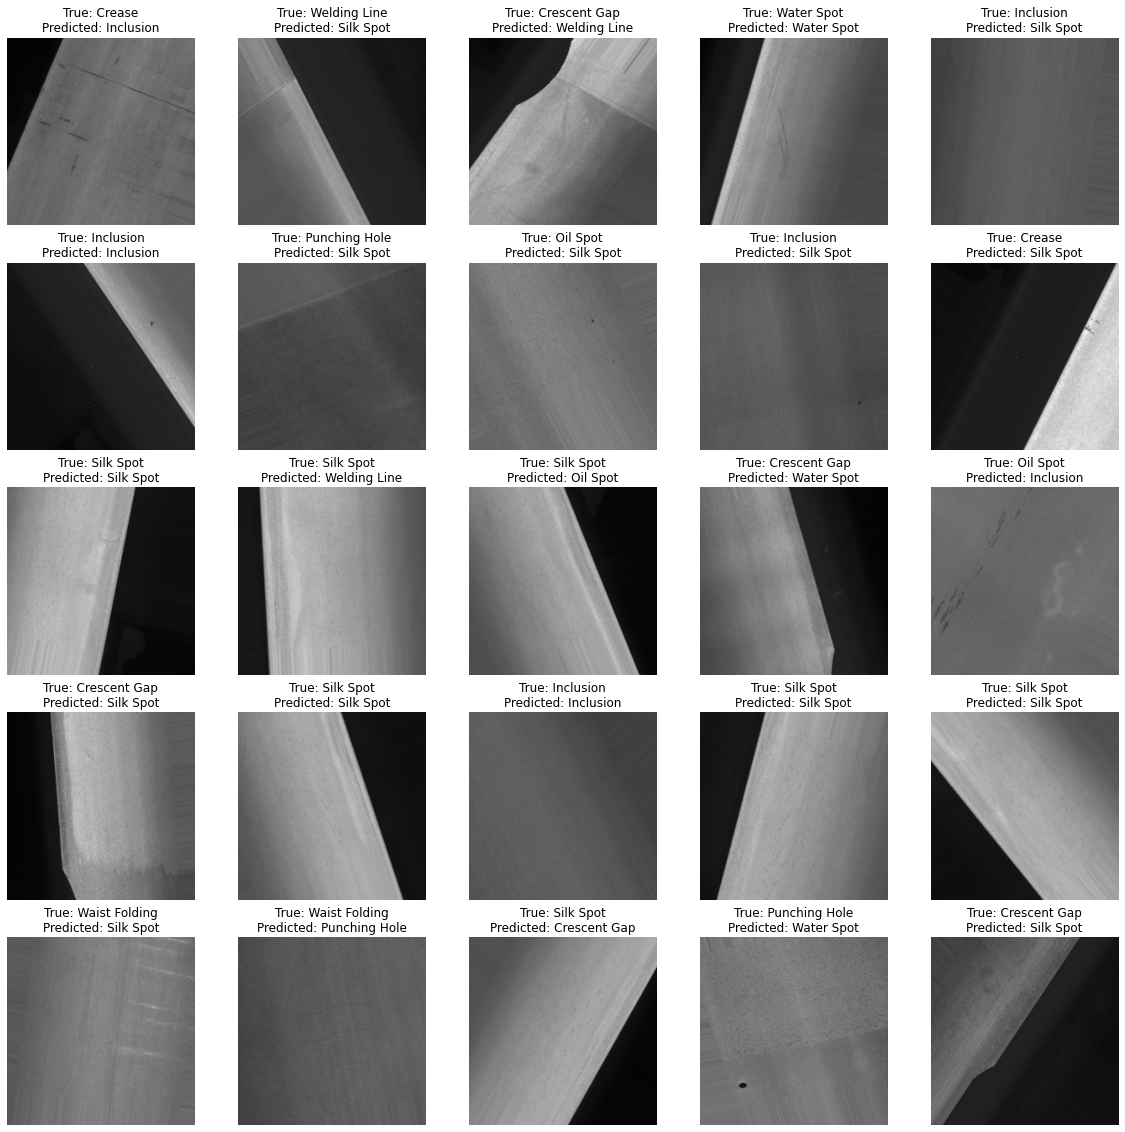

Total correct predictions: 7


In [11]:
predictions = model.predict(val_data_gen)
predicted_classes = np.argmax(predictions, axis=-1)
fig = plt.figure(figsize=(20, 20))
correct_prediction = 0
for i, image in enumerate(val_data_gen):
    ax = fig.add_subplot(5, 5, i+1)
    ax.imshow(image[0][0])
    ax.axis('off')
    ax.set_title(f"True: {class_names[np.argmax(image[1])]}\nPredicted: {class_names[predicted_classes[i]]}")
    if class_names[np.argmax(image[1])]==class_names[predicted_classes[i]]:
        correct_prediction += 1
    if i == 24:
        break
plt.show()
print(f"Total correct predictions: {correct_prediction}")


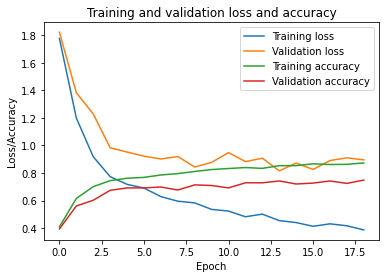

In [12]:
# Plot the training loss and accuracy
plt.figure()
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and validation loss and accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss/Accuracy')
plt.legend()
plt.show()

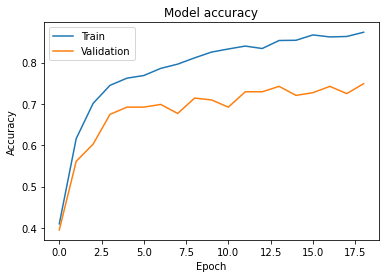

In [13]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


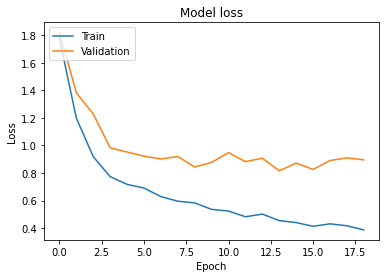

In [14]:
# Plot training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [15]:
model.save("InceptionV3.h5")